In [ ]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
import csv
import time
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os

# keras imports for the dataset and building our neural network
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#IMPORTANTE: PER COME SONO IMPORTATE LE CARTELLE PUÒ ANCHE ESSERE TOLTO 

#Impone ordinamento cartelle se hanno nomi di lunghezza diversa
def classificator (directory):
    childDirectories = next(os.walk(directory))[1]
    for x in range(len(childDirectories)):
        childDirectories[x]=int(childDirectories[x])
    childDirectories.sort()
    for x in range(len(childDirectories)):
        childDirectories[x]=str(childDirectories[x])
    return childDirectories

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#PREAMBOLO:
# 1. versione del dataset
# 2. imposto la dimensione della resize del modello
# 3. augmentation sul dataset di train e/o di test
# 4. early stopping o meno
# 5. addestramento del base_model
# 6. livello del base_learning_rate

# IMPOSTO MACROPARAMETRI E VARIABILI GLOBALI
epoche = 15
img_width, img_height = 32, 32
batch_size = 100
split_per_validazione = 0.15

# 1. versione del dataset
# settare 'sceltaDataset' come "10RandomClasses", "10PoorestClasses" o "43Classes"
sceltaDataset = "10RandomClasses"

# 2. imposto la dimensione della resize del modello
#Inserisci le dimensioni per la resize con interpolazione. Scegli tra i valori prefissati: '96, 96', '128, 128', '160, 160', '192, 192', 224, 224'
img_width_resized, img_height_resized = 96, 96

# 3. augmentation sul dataset di train e/o di test
# Se desideri l'augmentation del train o nel test imposta trainAg e/o testAg come 'SI'
trainAg = 'NO'
testAg = 'NO'

# 4. early stopping o meno
# Se desideri earlyStopping imposta la variabile a 'SI'
earlyStopping = 'SI'

#5. addestramento del base_model
#Se desideri che si addestri durante il train, imposta la variabile a 'True' (come boolean)
addestramentoBaseModel = True

#6. livello del base_learning_rate
base_learning_rate = 0.0001

In [ ]:
#CONTROLLI VARI

#CONTROLLO E SETTAGGIO DEL DATASET:
pathDrive = '/content/drive/My Drive/Colab Notebooks/'
if sceltaDataset == "10RandomClasses":
    numeroClassi = 10
    nomeZipDataset = 'TrafficSignClassification-10RandomClasses'
    nb_train_samples = 33000
    nb_test_samples = 3300
elif sceltaDataset == "10PoorestClasses":
    numeroClassi = 10
    nomeZipDataset = 'TrafficSignClassification-10PoorestClasses'
    nb_train_samples = 4400
    nb_test_samples = 720
elif sceltaDataset == "43Classes":
    numeroClassi = 43
    nomeZipDataset = 'TrafficSignClassification-43Classes'
    nb_train_samples = 65000
    nb_test_samples = 9000
else:
    raise SystemExit("Dataset non riconosciuto")
origine = pathDrive+nomeZipDataset

#CONTROLLO DIMENSIONE RESIZE
if (img_width_resized!=img_height_resized):
    raise SystemExit("La dimensione della resize deve essere quadrata. Controlla che img_width_resized e img_height_resized siano uguali")
elif (img_height_resized!=96 and img_height_resized!=128 and img_height_resized!=160 and img_height_resized!=192 and img_height_resized!=224):
    raise SystemExit("Dimensioni della resize non accettate")


#CREAZIONE PATH DI SALVATAGGIO COMUNE
creoNomeAddestramento='MobileNetCNN-'+sceltaDataset+'-'+str(epoche)+'Epoche-EarlyStopping'+earlyStopping+'-TrainAg'+trainAg+'-TestAg'+testAg+"-baseLearningRate"+str(base_learning_rate)
#Verifico se desidero l'addestramento del modello, prevengo possibili errori e aggiungo elemnto al pathName
if (addestramentoBaseModel==True):
    creoNomeAddestramento+="-AddestramentoBaseModelSI"
else:
    addestramentoBaseModel=False
    print("Addestramento base_model settato a false")
    creoNomeAddestramento+="-AddestramentoBaseModelNO"
pathSalvaModello=creoNomeAddestramento+'.h5'
pathStampaModello=pathDrive+'models/modelloDi'+sceltaDataset+'.png'
pathConfMatrix=pathDrive+'models/CONFUSION_MATRIX---'+creoNomeAddestramento+'.png'

#IMPOSTO L'AUGMENTANTION:
#Default:
train_shear_range, test_shear_range = 0.0, 0.0
train_zoom_range, test_zoom_range = 0.0, 0.0
train_width_shift_range, test_width_shift_range = 0.0, 0.0
train_height_shift_range, test_height_shift_range = 0.0, 0.0
train_fill_mode, test_fill_mode = "constant", "constant" #riempe i contorni in caso di modifica, messo costant così è nero
#Attivazione augmentation se richiesta
if trainAg == 'SI':
    train_shear_range=0.15 #Distorsione angolare. Ne distorce un po' la forma, quindi la tengo
    train_zoom_range=0.15 #Zoom da applicare alla foto. Ne distorce un po' la forma, quindi la tengo
    train_width_shift_range=0.15 #spostamento orizzontale della foto per analizzarla anche da tagliata
    train_height_shift_range=0.15 #spostamento verticale della foto per analizzarla anche da tagliata
if testAg == 'SI':
    test_shear_range=0.1
    test_zoom_range=0.1
    test_width_shift_range=0.1
    test_height_shift_range=0.1


#IMPOSTO EARLYSTOPPING:
if earlyStopping == 'SI':
    #Implemento l'EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
        baseline=None, restore_best_weights=False)
    checkpoint_filepath = '/tmp/checkpoint'
    epocheSalvataggio=5
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath, save_weights_only=True,
            monitor='val_loss', save_freq=epocheSalvataggio,
            save_best_only=True)
    callback = [ TensorBoard(update_freq=521),
                    EarlyStopping(monitor='val_accuracy', patience=2),
                    ModelCheckpoint(pathDrive+"results/"+pathSalvaModello, save_best_only=True), ]
else:
    callback = None

print("Nome Addestramento:")
print(creoNomeAddestramento)

Addestramento base_model settato a false
Nome Addestramento:
MobileNetCNN-10PoorestClasses-30Epoche-EarlyStoppingSI-TrainAgNO-TestAgNO-baseLearningRate0.0001-AddestramentoBaseModelNO


In [ ]:
#Importo e imposto dataset in COLAB
import zipfile

local_zip = origine+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()
  
base_dir = '/content/'+nomeZipDataset

# Directory del train
train_data_dir = base_dir+'/train'
# Directory del test
test_data_dir = base_dir+'/test'
# File con i nomi delle labels
label_info_dir = base_dir+'/labels.csv'


In [ ]:
def make_train_generator():
    # Configurazione di augmentation per il training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=split_per_validazione, #Quanto deve splittare il train per creare la validation
        shear_range=train_shear_range,
        zoom_range=train_zoom_range,
        width_shift_range=train_width_shift_range,
        height_shift_range=train_height_shift_range,
        fill_mode=train_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=int(nb_train_samples*(1-split_per_validazione)),
        class_mode='categorical',
        subset='training')
    return train_generator

def make_validation_generator():
    # Configurazione di augmentation per il training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=split_per_validazione, #Quanto deve splittare il train per creare la validation
        shear_range=train_shear_range,
        zoom_range=train_zoom_range,
        width_shift_range=train_width_shift_range,
        height_shift_range=train_height_shift_range,
        fill_mode=train_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=int(nb_train_samples*split_per_validazione),
        class_mode='categorical',
        subset='validation')
    return validation_generator

def make_test_generator():
    # Configurazione di augmentation per il test (solo rescaling nel caso non si voglia augmentation)
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=test_shear_range,
        zoom_range=test_zoom_range,
        width_shift_range=test_width_shift_range,
        height_shift_range=test_height_shift_range,
        fill_mode=test_fill_mode,
        horizontal_flip=False,
        vertical_flip=False
        #rotation_range=20, #Rotazione massima, espressa in intero. Disattiva perché i cartelli non si trovano ruotati
        )
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=nb_test_samples,
        class_mode="categorical")
    return test_generator

#IMPORTANTE: PER MAGGIOR INFO SULL'AUGMENTATION DELLA IMAGEDATAGENERATOR, E' RIPORTATO IL LINK:
#https://fairyonice.github.io/Learn-about-ImageDataGenerator.html

In [ ]:
#Importo i nomi delle classi
with open(label_info_dir, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
#elementi le prime entry che non sono dati utili
data.pop(0)
data.pop(0)
listaNomiClassi = [];
for i in range(len(data)):
    #Divido la riga per poi prendere l'elemento che mi serve
    rigaInEsame = data[i][0].split(";")
    listaNomiClassi+=[rigaInEsame[1]]

In [ ]:
#import del dataset usando tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(make_train_generator, (tf.float32, tf.float32))
validation_dataset = tf.data.Dataset.from_generator(make_validation_generator, (tf.float32, tf.float32))
test_dataset = tf.data.Dataset.from_generator(make_test_generator, (tf.float32, tf.float32))

In [ ]:
#ricavare immagini e label dai dataset creati con i generator
for images, labels in train_dataset.take(1):
    X_train = images.numpy()
    Y_train = labels.numpy()
    
for images, labels in validation_dataset.take(1):
    X_valid = images.numpy()
    Y_valid = labels.numpy()
    
for images, labels in test_dataset.take(1):
    X_test = images.numpy()
    Y_test = labels.numpy()

Found 3640 images belonging to 10 classes.
Found 635 images belonging to 10 classes.
Found 706 images belonging to 10 classes.


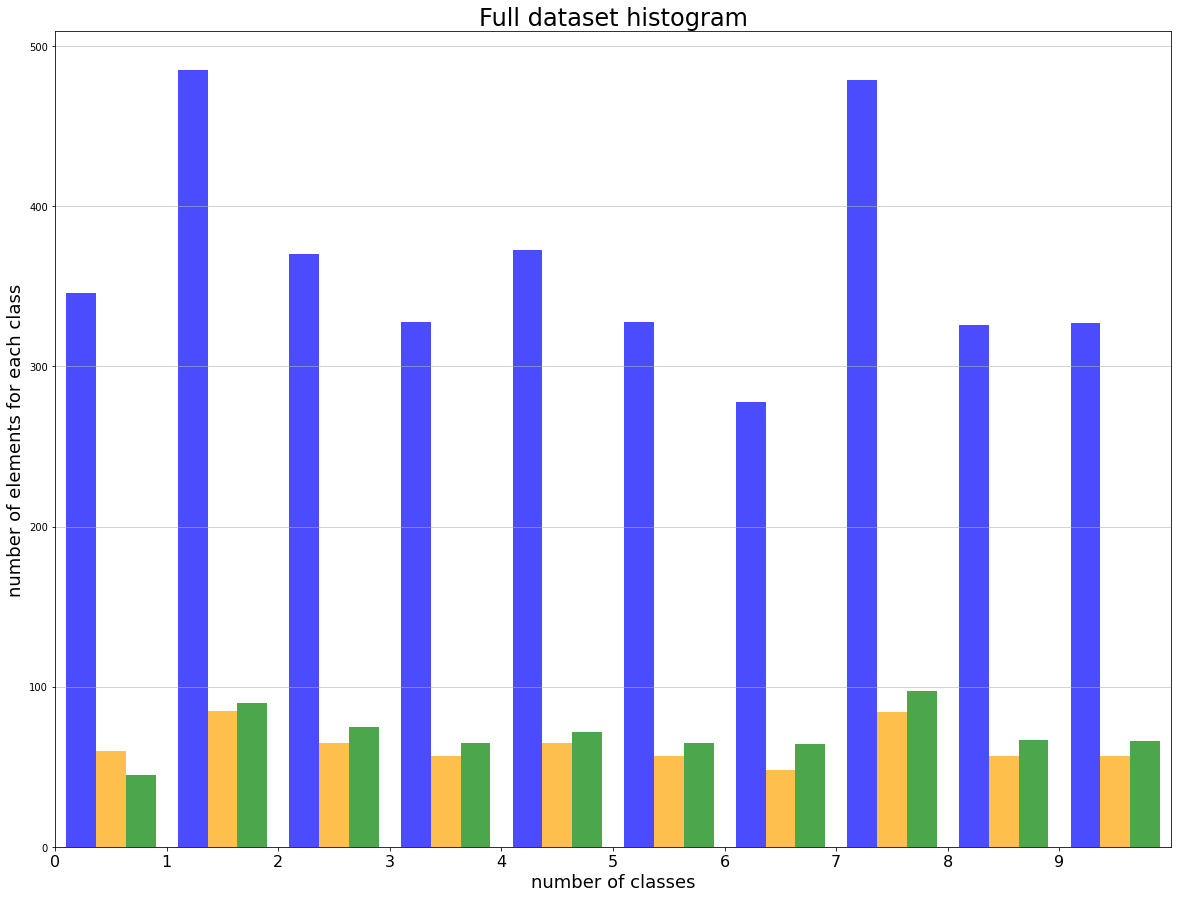

In [ ]:
#HISTOGRAM REPRESENTATION
#preliminari: conversione da one-hot-encoding a interi per visionare il numero di sample per dataset
y_train = np.empty(len(Y_train),dtype=int)
y_valid = np.empty(len(Y_valid),dtype=int)
y_test = np.empty(len(Y_test),dtype=int)
for j in range(len(Y_train)):
    #print(j, "/", len(Y_test), end='\r')
    y_train[j]=(np.where(Y_train[j]==1)[0][0])

for j in range(len(Y_valid)):
    #print(j, "/", len(Y_test), end='\r')
    y_valid[j]=(np.where(Y_valid[j]==1)[0][0])
    
for j in range(len(Y_test)):
    #print(j, "/", len(Y_test), end='\r')
    y_test[j]=(np.where(Y_test[j]==1)[0][0])

#Quest'ultima cosa serve per la stampa finale
immaginiPerLaStampaFinale=X_test    

#genero Valori Asse X
valAsseX = []
for i in range(numeroClassi):
    valAsseX+=[i]

#creo allineamento per i risultati dell'asse x
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    
plt.figure(num=None, figsize=(20, 15))
bins = range(numeroClassi+1)
plt.hist([y_train, y_valid, y_test], bins=bins, color=['blue', 'orange', 'green'], alpha=0.7)
bins_labels(bins, fontsize=16)
plt.xlabel("number of classes", fontsize=18)
plt.ylabel("number of elements for each class", fontsize=18)
plt.xticks(valAsseX)
plt.title('Full dataset histogram', fontsize=24)
plt.grid(axis='y', alpha=0.7)
#plt.savefig('models/hist'+sceltaDataset+'.png')
plt.show()

Digit: '0' corrisponde a 'Speed limit (20km/h)'
Digit: '4' corrisponde a 'Bicycles crossing'
Digit: '7' corrisponde a 'Roundabout mandatory'
Digit: '8' corrisponde a 'End of no passing'
Digit: '9' corrisponde a 'End of no passing by vehicles over 3.5 metric tons'


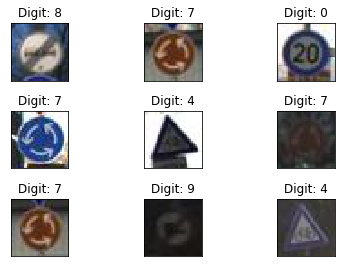

In [ ]:
#IMPORTANTE: LA STAMPA ORIGINALE NON VA BENE PERCHÉ NON ENTRANO I NOMI DELLE CLASSI, QUINDI NE HO SCRITTE DUE NUOVE.
#            UNA STAMPA UNA CLASSE A RIGA CON IL CORRISPETTIVO NOME, MENTRE L'ALTRA STAMPA I NOMI DELLE CLASSI
#            PRESENTI NELLA STAMPE E POI DOPO LE CLASSI CON IL RELATIVO NUMERO
#  

#Stampa prima delle classi presenti, con la corrispondente digits, e poi le immagini con la corrispondente digits
listaClassiCheVerrannoStampate = []
for i in range(9):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=np.where(Y_train[i]==1)[0][0]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    #Stampa classica delle digits
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], interpolation='none')
    plt.title("Digit: {}".format(valoreDigits))
    plt.xticks([])
    plt.yticks([])

#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
#Stampo i cartelli
plt.show()

In [ ]:
#MobileNetV2 ha delle dimensione prestabilite per quanto riguarda le immagini in input, quindi è necessaria una resize con interpolazione

print('dimensione train set precedente:',X_train.shape)
print('dimensione validation set precedente:',X_valid.shape)
print('dimensione test set precedente:',X_test.shape)

X_train_resized = []
X_valid_resized = []
X_test_resized = []

#Se il dataset e la dimensione della resize lo permettono, uso la reshape con interpolazione veloce, altrimenti quella lenta
if(sceltaDataset=="10PoorestClasses" or (sceltaDataset=="10RandomClasses" and img_height_resized<129)):
    print("\nImpostata la resize veloce, ma pesante computazionalmente.")
    def resize_dataset(dataset):
        dataset_resized = []
        for i in range(len(dataset)):
            dataset_resized.append(cv2.resize(dataset[i], dsize=(img_width_resized, img_height_resized), interpolation=cv2.INTER_CUBIC))
        dataset_resized = np.array(dataset_resized)
        return dataset_resized
else:
    print("\nImpostata la resize lenta, ma leggera computazionalmente.")
    def resize_dataset(dataset):
        dataset_resized = np.array(cv2.resize(dataset[0], dsize=(img_width_resized, img_height_resized), interpolation=cv2.INTER_CUBIC))
        dataset_resized = np.expand_dims(dataset_resized, axis=0)
        for i in range(1, len(dataset)):
            aux=np.array(cv2.resize(dataset[i], dsize=(img_width_resized, img_height_resized), interpolation=cv2.INTER_CUBIC))
                        #print(i)
                        #print(np.expand_dims(aux, axis=0).shape)
                        #print(dataset_resized.shape)
                        #print(dataset_resized.shape)
              #PROVO A DIMINUIRE IL NUMERO DI VARIABILI NELLA SPERANZA CHE SI VELOCIZZI L'ESECUZIONE
              #a = np.zeros(np.expand_dims(aux, axis=0).shape)
              #b = np.zeros(dataset_resized.shape)
            dataset_resized = np.concatenate((np.zeros(np.expand_dims(aux, axis=0).shape), np.zeros(dataset_resized.shape)))
        return dataset_resized

print("\nInizio la reshape con interpolazione del train.")
X_train_resized = resize_dataset(X_train)
print("Finito con il train, inizio la reshape con interpolazione della validation.")
X_valid_resized = resize_dataset(X_valid)
print("Finito con la validation, inizio la reshape con interpolazione del test.")
X_test_resized = resize_dataset(X_test)
print("Finito con il test.\n")

print('dimensione train set ridimensionato:',X_train_resized.shape)
print('dimensione valid set ridimensionato:',X_valid_resized.shape)
print('dimensione test set ridimensionato:',X_test_resized.shape)

dimensione train set precedente: (3640, 32, 32, 3)
dimensione validation set precedente: (635, 32, 32, 3)
dimensione test set precedente: (706, 32, 32, 3)

Impostata la resize veloce, ma pesante computazionalmente.

Inizio la reshape con interpolazione del train.
Finito con il train, inizio la reshape con interpolazione della validation.
Finito con la validation, inizio la reshape con interpolazione del test.
Finito con il test.

dimensione train set ridimensionato: (3640, 96, 96, 3)
dimensione valid set ridimensionato: (635, 96, 96, 3)
dimensione test set ridimensionato: (706, 96, 96, 3)


In [ ]:
IMG_SHAPE = (img_width_resized, img_height_resized, 3)

#creo un modello di base a partire dalla rete pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = addestramentoBaseModel

#architettura del modello base
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [ ]:
#creo due nuovi layer da aggiungere in coda al modello base per fare classificazione
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(numeroClassi, activation="softmax")

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#loss e accuracy prima dell'addestramento
loss_and_metrics = model.evaluate(X_test_resized, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

23/23 - 0s - loss: 2.2856 - accuracy: 0.1657
Test Loss 2.2856063842773438
Test Accuracy 0.16572238504886627


In [ ]:
#loss e accuracy dopo dell'addestramento
modello_cartelli = load_model(pathDrive+"results/"+pathSalvaModello)

loss_and_metrics = modello_cartelli.evaluate(X_test_resized, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

23/23 - 0s - loss: 2.3438 - accuracy: 0.1048
Test Loss 2.3437907695770264
Test Accuracy 0.10481586307287216



551  classified correctly
155  classified incorrectly

------------------------------------------------

Le prossime predizioni sono giuste

------------------------------------------------

Digit: '1' corrisponde a 'Dangerous curve to the right'
Digit: '2' corrisponde a 'Road narrows on the right'
Digit: '4' corrisponde a 'Bicycles crossing'
Digit: '5' corrisponde a 'End of all speed and passing limits'
Digit: '6' corrisponde a 'Go straight or left'


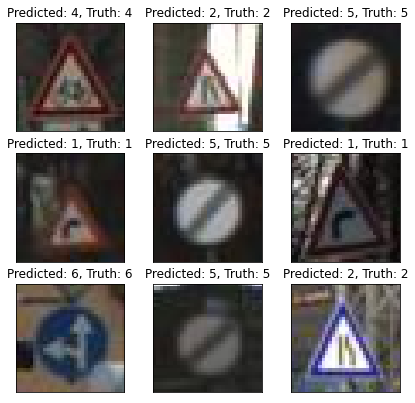


------------------------------------------------

Le prossime predizioni sono sbagliate

------------------------------------------------

Digit: '1' corrisponde a 'Dangerous curve to the right'
Digit: '2' corrisponde a 'Road narrows on the right'
Digit: '3' corrisponde a 'Pedestrians'
Digit: '4' corrisponde a 'Bicycles crossing'
Digit: '6' corrisponde a 'Go straight or left'
Digit: '7' corrisponde a 'Roundabout mandatory'
Digit: '8' corrisponde a 'End of no passing'
Digit: '9' corrisponde a 'End of no passing by vehicles over 3.5 metric tons'


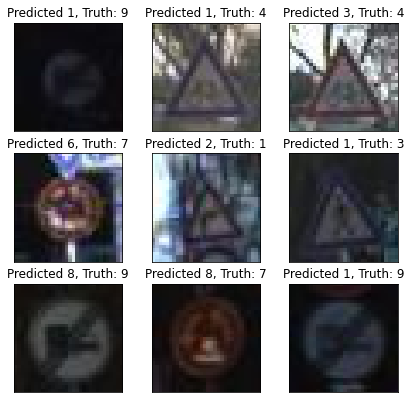

In [ ]:
# Creazione delle predizioni sul test set sulla base del modello caricato
predicted_classes = modello_cartelli.predict_classes(X_test_resized)

# Distinguo cosa è stato predetto bene e cosa no
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)
figure_evaluation = plt.figure()

print("\n------------------------------------------------\n")
print("Le prossime predizioni sono giuste")
print("\n------------------------------------------------\n")

listaClassiCheVerrannoStampate = []
# Stampa delle 9 predizioni corrette
for i, correct in enumerate(correct_indices[:9]):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=predicted_classes[correct]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    #Stampa classica delle digits
    plt.subplot(6,3,i+1)
    plt.imshow(immaginiPerLaStampaFinale[correct], interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])
    
#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
            
#Stampo i cartelli
plt.show()

print("\n------------------------------------------------\n")
print("Le prossime predizioni sono sbagliate")
print("\n------------------------------------------------\n")

listaClassiCheVerrannoStampate = []
# Stampa delle 9 predizioni incorrette
for i, incorrect in enumerate(incorrect_indices[:9]):
    #Creo la lista di classi e valori che verranno stampate
    valoreDigits=predicted_classes[incorrect]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]
    valoreDigits=y_test[incorrect]
    nomeDigits=listaNomiClassi[valoreDigits]
    if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate :
        listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]

    plt.subplot(6,3,i+10)
    plt.imshow(immaginiPerLaStampaFinale[incorrect], interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
    
#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
            
#Stampo i cartelli
plt.show()

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, predicted_classes, num_classes=numeroClassi)
tf.print(confusion_matrix, summarize=-1)

[[44 0 0 0 0 0 0 1 0 0]
 [0 76 5 3 5 0 0 1 0 0]
 [0 10 63 0 0 0 0 2 0 0]
 [0 7 11 41 6 0 0 0 0 0]
 [0 2 1 4 65 0 0 0 0 0]
 [0 0 0 0 0 64 0 0 1 0]
 [0 0 0 0 0 0 61 3 0 0]
 [0 10 1 0 0 12 4 67 3 0]
 [1 2 1 0 0 1 0 2 60 0]
 [0 13 0 0 0 5 1 5 32 10]]


In [ ]:
# ricerca dell'elemento con più errori (se può servire)
row = 0
col = 0
item = 0
for r in range(len(confusion_matrix)):
    for c in range(len(confusion_matrix[r])):
        if (r != c and confusion_matrix[r][c] > item):
            item = confusion_matrix[r][c]
            row = r
            col = c
print("elemento con più errori è in posizione [", row, "][", col, "] con numero errori pari a:",item.numpy())

elemento con più errori è in posizione [ 9 ][ 8 ] con numero errori pari a: 32


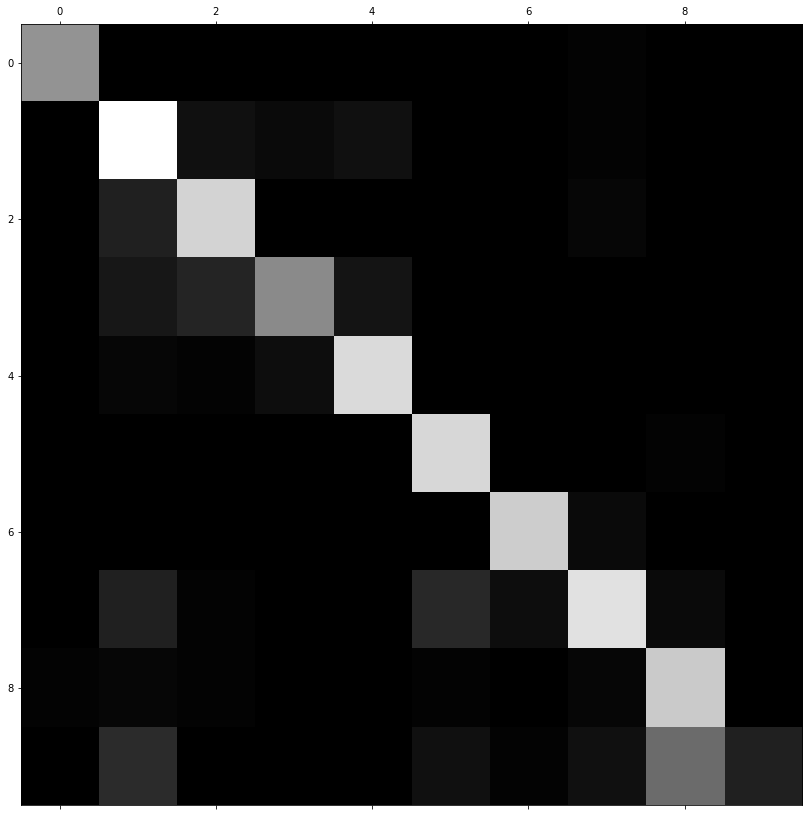

In [ ]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plt.matshow(confusion_matrix.numpy(), cmap=plt.cm.gray)
plt.savefig(pathConfMatrix)
plt.show()

In [ ]:
print("Nome Addestramento:")
print(creoNomeAddestramento)

Nome Addestramento:
MobileNetCNN-10RandomClasses-10Epoche-EarlyStoppingSI-TrainAgNO-TestAgNO-baseLearningRate0.0001-AddestramentoBaseModelSI
